In [ ]:
#weights = [0.1 1 1 1 1]
# gpu 5
# cell of checkpoints not included

In [ ]:
"""

clearly a problem in the database, the minimum number of the image is -0.1 (?)

good paper about losses:
https://arxiv.org/pdf/2006.14822.pdf

transfer learning in encoder with tumor relared neural network
how to implement dropout
number of parameters in network
resnet34 or densenet121

TODOs:

check the activation of layers --> https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4
implement shuffling in the generator --> https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb // https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly 
"""

In [ ]:
# from tensorflow.keras import layers
# from tensorflow import keras
# import segmentation_models as sm

# def get_model_with_dropout(base_model_name='efficientnetb4',activation='sigmoid',dropout = 0.1):
#     base_model = sm.Unet(base_model_name, encoder_weights='imagenet')
#     base_model_input = base_model.input
#     base_model_output = base_model.get_layer('final_conv').output
#     #add dropout
#     base_model_output = keras.layers.Dropout(dropout)(base_model_output)
#     #add activation
#     output = keras.layers.Activation(activation, name=activation)(base_model_output)
#     model_dp = keras.models.Model(base_model_input, output)

#     return model_dp

In [1]:
import os
from tensorflow.python.client import device_lib
import tensorflow as tf

def get_available_devices():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos]

#Run from server

gpu7 = "GPU-71b4cdfc-e381-0b98-9b24-4fc06284b496" 
gpu5 = "GPU-99d0769a-9f86-4800-a40e-2320dddcf5d1" 
gpu6 = "GPU-7423cfb5-cff4-ec4d-7e96-ea6e1591d56f"
gpu4 = "GPU-c0a8738f-6dd0-1b78-c38f-4969fd3886a8"

os.environ["CUDA_VISIBLE_DEVICES"]= gpu5# + "," + gpu6
print(get_available_devices())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

['/device:CPU:0', '/device:XLA_CPU:0', '/device:XLA_GPU:0', '/device:GPU:0']
Num GPUs Available:  1


In [2]:
import nibabel as nib
import matplotlib.pyplot as plt
import numpy as np
import h5py
import cv2
import pickle
import time
from numpy.core.umath_tests import inner1d

/home/spablo/virtualenvironment/project_2/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  


In [3]:
from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import History

from helperFunctions import visualize, denormalize, visualize_histories, load_images_from_hdf5
from model import *

In [4]:
IMG_HEIGHT = 240
IMG_WIDTH = 240
IMG_DEPTH = 155

IMG_HEIGHT_UNET = 256
IMG_WIDTH_UNET = 256

N_IMG = 369
length_file = IMG_DEPTH * N_IMG
# h5py_file_name = 'delete.hdf5'
#h5py_file_name = 'brats2020_full_normalized.hdf5'
smooth = 1e-4

train_size = 250 * IMG_DEPTH
valid_size = 69 * IMG_DEPTH
test_size = 50 * IMG_DEPTH

train_begin = 0
train_stop = (250 * IMG_DEPTH) 
valid_begin = 250 * IMG_DEPTH
valid_stop = ((250 + 69) * IMG_DEPTH) 
test_begin = ((250 + 69) * IMG_DEPTH)
n_images = N_IMG * IMG_DEPTH 

n_channels = 3

CLASSES = ['0','1','2','3','4']
LR = 1e-4
EPOCHS = 10
n_classes = 5
BATCH_SIZE = 32

dropout = 0.2
reducing_factor = 8

In [ ]:
n_images

In [5]:
train_images = np.zeros((IMG_HEIGHT, IMG_WIDTH, train_size, n_channels))
valid_images = np.zeros((IMG_HEIGHT, IMG_WIDTH, valid_size, n_channels))
test_images = np.zeros((IMG_HEIGHT, IMG_WIDTH, test_size, n_channels))

train_labels = np.zeros((IMG_HEIGHT, IMG_WIDTH, train_size))
valid_labels = np.zeros((IMG_HEIGHT, IMG_WIDTH, valid_size))
test_labels = np.zeros((IMG_HEIGHT, IMG_WIDTH, test_size))

In [6]:
# path_directory = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
# dataset_directory = os.path.join("..","data","can_be_deleted.hdf5")

h5py_file_name = 't1_images.hdf5'

path_directory = os.path.join("..","data","MICCAI_BraTS2020_TrainingData")
dataset_directory_t1 = os.path.join("..","data", 't1_images.hdf5')
dataset_directory_t1ce = os.path.join("..","data", 't1ce_images.hdf5')
dataset_directory_t2 = os.path.join("..","data", 't2_images.hdf5')
dataset_directory_flair = os.path.join("..","data", 'flair_images.hdf5')
dataset_directory_seg = os.path.join("..","data", 'seg_images.hdf5')

___

Load data and model

In [7]:
#train_images[...,0], valid_images[...,0] = load_images_from_hdf5(dataset_directory_t1,train_begin,train_stop,n_images)
train_images[...,1] = load_images_from_hdf5(dataset_directory_t1ce, train_begin, train_stop)
valid_images[...,1] = load_images_from_hdf5(dataset_directory_t1ce, valid_begin, valid_stop)
#test_images[...,1] = load_images_from_hdf5(dataset_directory_t1ce, test_begin, test_stop)

In [8]:
train_images[...,2] = load_images_from_hdf5(dataset_directory_t2, train_begin, train_stop)
valid_images[...,2] = load_images_from_hdf5(dataset_directory_t2, valid_begin, valid_stop)
#test_images[...,2] = load_images_from_hdf5(dataset_directory_t2, test_begin, test_stop)

In [9]:
train_images[...,0] = load_images_from_hdf5(dataset_directory_flair, train_begin, train_stop)
valid_images[...,0] = load_images_from_hdf5(dataset_directory_flair, valid_begin, valid_stop)
#test_images[...,0] = load_images_from_hdf5(dataset_directory_flair, test_begin, test_stop)

In [10]:
np.shape(test_labels)

(240, 240, 7750)

In [11]:
train_labels = load_images_from_hdf5(dataset_directory_seg, train_begin, train_stop)
valid_labels = load_images_from_hdf5(dataset_directory_seg, valid_begin, valid_stop)
#test_labels = load_images_from_hdf5(dataset_directory_seg, test_begin, test_stop)

In [12]:
np.shape(valid_images)

(240, 240, 10695, 3)

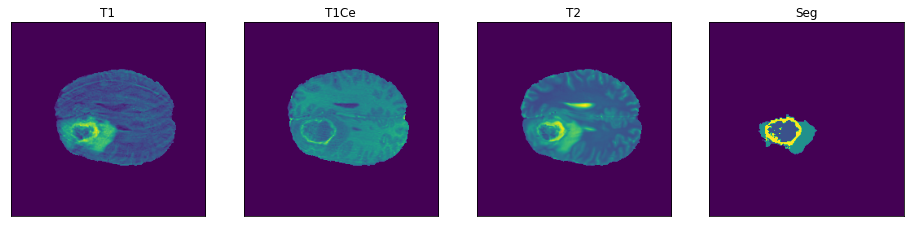

In [13]:
slice_num = 99

visualize(
    t1=train_images[...,slice_num,0].squeeze(),
    t1ce=train_images[...,slice_num,1].squeeze(),
    t2=train_images[...,slice_num,2].squeeze(),
    #flair=train_images[...,slice_num,3].squeeze(),
    seg=train_labels[...,slice_num].squeeze(),
)

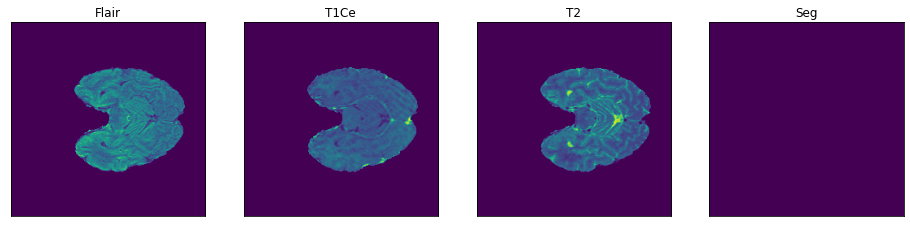

In [14]:
slice_num = 200

visualize(
    flair=valid_images[...,slice_num,0].squeeze(),
    t1ce=valid_images[...,slice_num,1].squeeze(),
    t2=valid_images[...,slice_num,2].squeeze(),
    #flair=valid_images[...,slice_num,3].squeeze(),
    seg=valid_labels[...,slice_num].squeeze(),
)

____

In [15]:
class Dataset:
    
    def __init__(self, images_train, images_label, classes = CLASSES):
        
        self.images_fps = images_train
        self.masks_fps = images_label
        self.classes = classes
        self.class_values = [self.classes.index(cls.lower()) for cls in self.classes]
        self.ids = np.shape(self.images_fps)[2]
    
    def __getitem__(self, i):
        
        X_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, n_channels))
        y_new = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET))
        
        X_new[:IMG_HEIGHT,:IMG_HEIGHT,0] = self.images_fps[:,:,i,0]
        X_new[:IMG_HEIGHT,:IMG_HEIGHT,1] = self.images_fps[:,:,i,1]
        X_new[:IMG_HEIGHT,:IMG_HEIGHT,2] = self.images_fps[:,:,i,2]
        #X_new[:IMG_HEIGHT,:IMG_HEIGHT,3] = self.images_fps[:,:,i,3]
               
        y_new[:IMG_HEIGHT,:IMG_HEIGHT] = self.masks_fps[:,:,i]
        
        return X_new, tf.keras.utils.to_categorical(y_new, num_classes=n_classes)
    
    def __len__(self):
        
        return self.ids

In [16]:
class Dataloder(tf.keras.utils.Sequence):
    
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=BATCH_SIZE, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        #self.indexes = np.arange(len(dataset))
        self.on_epoch_end()

    def __getitem__(self, index):
        
        #t = time.time()
        
        if "data" in dir():
            del data
        if "batch" in dir():
            del batch
        
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [np.arange(len(self.dataset))[k] for k in indexes]

        data = []
        batch = []
        
        for j in list_IDs_temp:

            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        
        #elapsed = time.time() - t
        #print(elapsed)

        return (batch[0],batch[1])
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.indexes) / self.batch_size))
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        self.indexes = np.arange(len(self.dataset))
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)  

In [17]:
from sklearn.utils.extmath import cartesian

#calculates dice considering an input with a single class
def dice_single(true,pred):
    true = K.batch_flatten(true)
    pred = K.batch_flatten(pred)
    pred = K.round(pred)

    intersection = K.sum(true * pred, axis=-1)
    true = K.sum(true, axis=-1)
    pred = K.sum(pred, axis=-1)

    return ((2*intersection) + K.epsilon()) / (true + pred + K.epsilon())

def dice_inner_0(true,pred,index=0):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_1(true,pred,index=1):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_2(true,pred,index=2):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_3(true,pred,index=3):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

def dice_inner_4(true,pred,index=4):

    #get only the desired class
    true = true[:,:,:,index]
    pred = pred[:,:,:,index]

    #return dice per class
    return dice_single(true,pred)

# def HausdorffDist(A,B):
#     # https://github.com/zhengyang-wang/3D-Unet--Tensorflow/blob/master/utils/HausdorffDistance.py
#     D_mat = np.sqrt(inner1d(A,A)[np.newaxis].T + inner1d(B,B)-2*(np.dot(A,B.T)))
#     # Find DH
#     dH = np.max(np.array([np.max(np.min(D_mat,axis=0)),np.max(np.min(D_mat,axis=1))]))
#     return(dH)

def weighted_hausdorff_distance(w, h, alpha = 0.95):
    all_img_locations = tf.convert_to_tensor(cartesian([np.arange(w),
                                               np.arange(h)]), dtype=tf.float32)
    max_dist = math.sqrt(w ** 2 + h ** 2)

    def hausdorff_loss(y_true, y_pred):
        def loss(y_true, y_pred):
            eps = 1e-6
            y_true = K.reshape(y_true, [w, h])
            gt_points = K.cast(tf.where(y_true > 0.5), dtype=tf.float32)
            num_gt_points = tf.shape(gt_points)[0]
            y_pred = K.flatten(y_pred)
            p = y_pred
            p_replicated = tf.squeeze(K.repeat(tf.expand_dims(p, axis=-1), 
                                                num_gt_points))
            d_matrix = cdist(all_img_locations, gt_points)
            num_est_pts = tf.reduce_sum(p)
            term_1 = (1 / (num_est_pts + eps)) * K.sum(p * K.min(d_matrix, 1))

            d_div_p = K.min((d_matrix + eps) / (p_replicated ** alpha + (eps / max_dist)), 0)
            d_div_p = K.clip(d_div_p, 0, max_dist)
            term_2 = K.mean(d_div_p, axis=0)

            return term_1 + term_2

        batched_losses = tf.map_fn(lambda x:
                                   loss(x[0], x[1]),
                                   (y_true, y_pred),
                                   dtype=tf.float32)
        return K.mean(tf.stack(batched_losses))

    return hausdorff_loss

def DiceScore(individual_dices):
    #individual_dices: array containing dice scores for each class
    return np.mean(individual_dices)

def Sensitivity(TP, FN):
    return TP / (TP + FN)

def Specificity(TN, FP):
    return TN / (FP + TN)

metrics_test5 = [dice_inner_0, dice_inner_1, dice_inner_2, dice_inner_3, dice_inner_4]

In [18]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    dice_inner_0, 
    dice_inner_1, 
    dice_inner_2, 
    dice_inner_3, 
    dice_inner_4,
]

In [19]:
def weighted_categorical_crossentropy(weights):
    def wcce(y_true, y_pred):
        Kweights = K.constant(weights)
        if not tf.is_tensor(y_pred): y_pred = K.constant(y_pred)
        y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    return wcce

In [20]:
def average(x, per_image=False, class_weights=None, **kwargs):
    if per_image:
        x = K.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return K.mean(x)

def my_func(arg):
    arg = tf.convert_to_tensor(arg, dtype=tf.float32)
    return arg

def dice_loss_weighted(y_true, y_pred):
    
    arg = my_func([dice_inner_0(y_true, y_pred),dice_inner_1(y_true, y_pred),dice_inner_2(y_true, y_pred),dice_inner_3(y_true, y_pred),dice_inner_4(y_true, y_pred)])
    score = average(arg)
    return  1-score

In [21]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel_loss(y_true, y_pred, numLabels=5):
    dice=0
    for index in range(numLabels):
        dice -= dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    print(dice)
    return 1+dice



In [22]:
def dice_coef_multilabel_loss(y_true, y_pred, numLabels=3, class_weights = [0,1,2]):
    dice=0
    #sth = tf.Variable(np.empty((), dtype='float32'))
    #sth = []
    for index in range(numLabels):
        dice = tf.unstack(dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index]))
        #sth = tf.concat([sth,dice],axis=0)
        #sth.append(dice)
    weighted_dice = K.constant(sth) * K.constant(class_weights)
    return K.constant(1 - np.mean(weighted_dice))

In [23]:
weights = [0.1,1.8,1.2,0.01,1.2]
#weights = None

In [24]:
def f_score_loss(gt, pr, beta=1, class_weights=weights, class_indexes=None, smooth=smooth, per_image=False, threshold=None, **kwargs):
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    fn = K.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return 1-score

In [25]:
def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes"""
    backend = K
    if backend.image_data_format() == 'channels_last':
        x = backend.permute_dimensions(x, (3, 0, 1, 2))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
        x = backend.gather(x, indexes)
        x = backend.permute_dimensions(x, (1, 0, 2, 3))
    return x

def get_reduce_axes(per_image, **kwargs):
    backend = K
    axes = [1, 2] if backend.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes

def gather_channels(*xs, indexes=None, **kwargs):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs

def round_if_needed(x, threshold, **kwargs):
    backend = K
    if threshold is not None:
        x = backend.greater(x, threshold)
        x = backend.cast(x, backend.floatx())
    return x

def iou_score_loss(gt, pr, class_weights=weights, class_indexes=None, smooth=smooth, per_image=False, threshold=None, **kwargs):
    backend = K
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = backend.sum(gt * pr, axis=axes)
    union = backend.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    print(score)
    score = average(score, per_image, class_weights, **kwargs)

    return 1-score


In [26]:

#loss = weighted_categorical_crossentropy(weights)
# loss = dice_niftynet
loss = f_score_loss
optim = tf.keras.optimizers.Adam(LR)

In [27]:
model = unet(
    pretrained_weights = None,
    input_size = (IMG_HEIGHT_UNET,IMG_WIDTH_UNET,n_channels),
    dropout = dropout,
    reducing_factor = reducing_factor,
    n_classes = n_classes)
model.compile(optim, loss=loss, metrics = METRICS)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [28]:
# tf.debugging.set_log_device_placement(True)
# with tf.device('/CPU:0'):

train_dataset = Dataset(train_images, train_labels, classes=CLASSES)
valid_dataset = Dataset(valid_images, valid_labels, classes=CLASSES)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, n_channels)
assert train_dataloader[0][1].shape == (BATCH_SIZE, IMG_HEIGHT_UNET, IMG_WIDTH_UNET, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
# callbacks = [
#     tf.keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
#     tf.keras.callbacks.ReduceLROnPlateau(),
# ]

# callbacks = [
#     tf.keras.callbacks.ReduceLROnPlateau(),
# ]

In [29]:
class printbatch(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, epoch, logs={}):

        res_dir = os.path.join("..","data","test_images")

        try:
            os.makedirs(res_dir)
        except:
            print(f"{res_dir} directory already exist")

    
#     def on_train_batch_begin(self, batch, logs=None):
#         keys = list(logs.keys())
#         print("...Training: start of batch {}; got log keys: {}".format(batch, keys))

#     def on_train_batch_end(self, batch, logs=None):
#         keys = list(logs.keys())
#         print("...Training: end of batch {}; got log keys: {}".format(batch, keys))

    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        
#         res_dir = os.path.join("..","data","test_images")
    
#         x_img = os.path.join(res_dir,"X_input.jpg")
#         y_img = os.path.join(res_dir,"Y_truth.jpg")
#         predicted_img = os.path.join(res_dir,f"{epoch}_Y_predicted.jpg")
        
#         image, gt_mask = train_dataset[100]
#         #image = np.expand_dims(image, axis=0)
#         pr_mask = self.model.predict(image[np.newaxis, ...])
    
#         gt_mask_vis = gt_mask[...,0:3]
#         pr_mask_vis = pr_mask[...,0:3]

# #         visualize(
# #             image=denormalize(image.squeeze()),
# #             gt_mask_vis=gt_mask_vis.squeeze(),
# #             pr_mask_vis=pr_mask_vis.squeeze(),
# #         )

#         cv2.imwrite(x_img, image[:,:,0])
#         cv2.imwrite(y_img, gt_mask_vis.squeeze())
#         cv2.imwrite(predicted_img, pr_mask_vis.squeeze())
#         cv2.imwrite(predicted_img, prediction[0,:,:,:] * 255.)
        
        
        print("End epoch {} of training; got log keys: {}".format(epoch, keys))
        
# pb = printbatch()        

In [ ]:
checkpoint_path =  os.path.join("..","data","checkpoints","training_0211/cp-{epoch:04d}.ckpt")
checkpoint_dir = os.path.dirname(checkpoint_path)

STEPS_PER_EPOCH = train_stop / BATCH_SIZE
SAVE_PERIOD = 5

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True,
    save_freq=int(SAVE_PERIOD * STEPS_PER_EPOCH)
    )

# history_callback = tf.keras.callbacks.CSVLogger('history.csv',separator=',',append=False)

# callbacks = [pb, cp_callback]


In [ ]:
image, mask = valid_dataset[80]

visualize(
    image=image[...,2], ### if putting the whole image, black and white, could it be the reason of the problem??
    no_tumor=mask[..., 0].squeeze(),
    one=mask[..., 1].squeeze(),
    two=mask[..., 2].squeeze(),
    three=mask[..., 3].squeeze(),
    four=mask[..., 4].squeeze(),
)

In [ ]:
SOF = 99
image, mask = train_dataset[SOF]

visualize(
    image_flair=image[...,0], ### if putting the whole image, black and white, could it be the reason of the problem??
    image_t1ce=image[..., 1].squeeze(),
    image_t2=image[..., 2].squeeze(),
    data_flair=train_images[..., SOF,0].squeeze(),
    data_t1ce=train_images[..., SOF, 1].squeeze(),
    data_t2=train_images[..., SOF,2].squeeze(),
)

In [ ]:
np.shape(mask[...,0]), np.shape(image[...,0])

In [ ]:
visualize(
    original_image = train_images[...,100,0],
    original_labels = train_labels[...,100],
    weight_map = weight_map
)

In [ ]:
np.min(weight_map)

In [ ]:
history = model.fit(
    train_dataloader,
    epochs=EPOCHS,
    verbose = 1,
    validation_data=valid_dataloader, 
)

In [ ]:
tf.trainable_variables()

In [ ]:
"""
Solutions to RAM memory problem

    def __del__(self):
        #put termination message
        for i in range(self._workers)
            self._notificationQueue.put("terminate")
        #empty queues, otherwise the workers won't terminate
        for i in range(self._max_queue_size):
            self._batchQueue.get(timeout=10)
            

"""

___

### Check for activation of weights

In [ ]:
# https://awjuliani.medium.com/visualizing-neural-network-layer-activation-tensorflow-tutorial-d45f8bf7bbc4


def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)
    
    
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")
        

In [ ]:
model.layers[0]

In [ ]:
imageToUse = image[:,:,0]
plt.imshow(np.reshape(imageToUse,[256,256]), interpolation="nearest", cmap="gray")

In [ ]:
image

### MultiGPU and Other Add-ons

In [ ]:
# https://github.com/naomifridman/Unet_Brain_tumor_segmentation/blob/master/multiple_gpu_Brats_Unet_segmentation_train_and_predict_ver1.ipynb

In [ ]:
from keras.utils import multi_gpu_model

# Instantiate the base model (or "template" model).
# We recommend doing this with under a CPU device scope,
# so that the model's weights are hosted on CPU memory.
# Otherwise they may end up hosted on a GPU, which would
# complicate weight sharing.
with tf.device('/cpu:0'):
    model = model_unet.unet(input_size = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS))

# Replicates the model on 8 GPUs.
# This assumes that your machine has 8 available GPUs.
parallel_model = multi_gpu_model(model, gpus=8)
parallel_model.compile(loss='categorical_crossentropy',
                       optimizer = Adam(lr = 0.0001),
                      metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

earlystopper = EarlyStopping(patience=8, verbose=1)
checkpointer = ModelCheckpoint(filepath = 'model_unet_4ch_3.hdf5',
                               verbose=1,
                               save_best_only=True, save_weights_only = True)

checkpointer2 = ModelCheckpoint(filepath = 'model_unet_best_acc_4ch_3.hdf5',
                               verbose=1, monitor='val_accuracy',
                               save_best_only=True, save_weights_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.000001, verbose=1,  cooldown=1)

In [ ]:
parallel_model.load_weights('model_unet_4ch_2.hdf5')

In [ ]:
%%time
history3 = parallel_model.fit_generator(gen_train,steps_per_epoch=20,
                                        #validation_data =( imtest,lbtest), 
                              validation_data =gen_test_im, validation_steps=2,
                                          
                              epochs=100,
                    callbacks=[earlystopper, checkpointer, checkpointer2])

### Visualizing results

In [ ]:
def visualize_im(colormap,**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap = colormap)
    plt.show()

def visualize_contour(colormap,**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.contour(np.flipud(image), [0.01, 0.5, 0.95], cmap = colormap)
    plt.show()
    
# helper function for data visualization    
def denormalize_im(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

def visualize_histories(**images):
    """Import as tuples: one = (a,b)"""
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.ylim(0,1)
        plt.xlabel('epoch')
        if i == 0:
            plt.ylabel('dice_score')
        plt.title(' '.join(name.split('_')).title())
        plt.plot(np.asarray(image[0]))
        plt.plot(np.asarray(image[1]))
        plt.legend(['train', 'val'])
    plt.show()

In [ ]:
visualize_histories(
    class_zero = (history.history['dice_inner_0'], history.history['val_dice_inner_0']), ### if putting the whole image, black and white, could it be the reason of the problem??
    class_one = (history.history['dice_inner_1'], history.history['val_dice_inner_1']),
    class_two = (history.history['dice_inner_2'], history.history['val_dice_inner_2']),
    class_three = (history.history['dice_inner_3'], history.history['val_dice_inner_3']),
    class_four = (history.history['dice_inner_4'], history.history['val_dice_inner_4'])
)

In [ ]:
from sklearn.metrics import plot_confusion_matrix

def FPR(FP,TN):
    return FP/(FP + TN)

def FNR(FN,TP):
    return FN/(FN + TP)


sensitivity_train = Sensitivity(np.array(history.history['tp']),np.array(history.history['fn']))
specificity_train = Specificity(np.array(history.history['tn']),np.array(history.history['fp']))
FPR_train = FPR(np.array(history.history['fp']),np.array(history.history['tn']))
FNR_train = FNR(np.array(history.history['fn']),np.array(history.history['tp']))
dice_score_train = DiceScore([history.history['dice_inner_0'],history.history['dice_inner_1'],history.history['dice_inner_2'],history.history['dice_inner_4']])

print("Train: sensitivity: ", sensitivity_train[-1], ", specificity: ", specificity_train[-1], ", dice score: ", dice_score_train)

sensitivity_val = Sensitivity(np.array(history.history['val_tp']),np.array(history.history['val_fn']))
specificity_val = Specificity(np.array(history.history['val_tn']),np.array(history.history['val_fp']))
FPR_train = FPR(np.array(history.history['val_fp']),np.array(history.history['val_tn']))
FNR_train = FNR(np.array(history.history['val_fn']),np.array(history.history['val_tp']))
dice_score_val = DiceScore([history.history['val_dice_inner_0'],history.history['val_dice_inner_1'],history.history['val_dice_inner_2'],history.history['val_dice_inner_4']])

print("Validation: sensitivity: ", sensitivity_val[-1], ", specificity: ", specificity_val[-1], ", dice score: ", dice_score_val)

total_pixels_train = np.array(history.history['tp'])[-1] + np.array(history.history['fp'])[-1] + np.array(history.history['fn'])[-1] + np.array(history.history['tn'])[-1]
total_pixels_val = np.array(history.history['val_tp'])[-1] + np.array(history.history['val_fp'])[-1] + np.array(history.history['val_fn'])[-1] + np.array(history.history['val_tn'])[-1]

confusion_mat_train = [[np.array(history.history['tp'])[-1],np.array(history.history['fp'])[-1]],[np.array(history.history['fn'])[-1],np.array(history.history['tn'])[-1]]]
confusion_mat_val = [[np.array(history.history['val_tp'])[-1],np.array(history.history['val_fp'])[-1]],[np.array(history.history['val_fn'])[-1],np.array(history.history['val_tn'])[-1]]]/total_pixels_val



In [ ]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(confusion_mat_val, range(2), range(2))
# plt.figure(figsize=(10,7))
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt=".2%", xticklabels=["1","0"], yticklabels=["1","0"]) # font size
plt.xlabel('true')
plt.ylabel('prediction')
plt.title('Confusion matrix Validation set')
"""
wrong labels!!!
"""

plt.show()

In [ ]:
# Plot training & validation iou_score values
# plt.figure(figsize=(30, 5))
# plt.subplot(121)
# plt.plot(history.history['f1-score'])
# plt.plot(history.history['val_f1-score'])
# plt.title('Model f1-score')
# plt.ylabel('f1-score')
# plt.xlabel('Epoch')
# plt.ylim([0,1])
# plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim([0,1])
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
n = 1
# ids = np.random.choice(np.arange(len(labels_train)), size=n)
ids = [80]
for i in ids:
    
    image, gt_mask = valid_dataset[i]
    #image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image[np.newaxis, ...])
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[...,4].squeeze(),
        pr_mask=pr_mask[...,4].squeeze(),
    )

In [ ]:
n = 1
# ids = np.random.choice(np.arange(len(labels_train)), size=n)
ids = [80]
for i in ids:
    
    image, gt_mask = valid_dataset[i]
    #image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image[np.newaxis, ...])
    
    visualize_im(
        image=denormalize_im(image.squeeze()),
        gt_mask=gt_mask[...,4].squeeze(),
        pr_mask=pr_mask[...,4].squeeze(),
    )


___

Saving Weights
___

In [ ]:
checkpoint_path= os.path.join("..","data","checkpoints","simple_unet_50_epochs.ckpt")

In [ ]:
model.save_weights(checkpoint_path)

In [ ]:
# Restore the weights
checkpoint_path = os.path.join('..', 'data', 'checkpoints')
checkpoint_number = 'cp-0040.ckpt'
checkpoint_path = os.path.join(checkpoint_path, checkpoint_number)
model.load_weights(checkpoint_path)

In [ ]:
image, gt_mask = valid_dataset[100]
model.evaluate(image[np.newaxis, ...], gt_mask[np.newaxis, ...], verbose=2)

___

In [ ]:
img_number = 200
simulation_number = 20
simulation_array = np.zeros((IMG_HEIGHT_UNET, IMG_WIDTH_UNET, n_classes, simulation_number))
image, gt_mask = valid_dataset[img_number]

for i in range(simulations_number):
    simulation_array[...,i] = model.predict(image[np.newaxis, ...]) #axis added where the number of batches goes

probability_map_mean = np.mean(simulation_array,axis=3)
probability_map_std = np.std(simulation_array,axis=3)

In [ ]:
from PIL import Image

In [ ]:
img_test_probability_4_std = probability_map_std[...,2]
plt.imshow(img_test_probability_4_std)

In [ ]:
np.shape(probability_map_std)

In [ ]:
zoom = [100,200]
np.shape(zoom)

In [ ]:
class_number = 2
img_test_probability_4 = probability_map[100:200,100:200,4]
img_test_probability_2 = probability_map[100:200,100:200,2]
#plt.imshow(img_test_probability_4,cmap = 'RdYlGn')

visualize_im('viridis',
             image = image[...,0],
             background = gt_mask[...,0],
             one = gt_mask[...,1],
             two = gt_mask[...,2],
    four = gt_mask[...,4],)

visualize_im('viridis',
             image = image[100:200,100:200,0],
             background = gt_mask[100:200,100:200,0],
             one = gt_mask[100:200,100:200,1],
             two = gt_mask[100:200,100:200,2],
    four = gt_mask[100:200,100:200,4],)

visualize_im('RdYlGn',
          image = image[100:200,100:200,0],
          background = probability_map[100:200,100:200,0],
             one = probability_map[100:200,100:200,1],
             two = probability_map[100:200,100:200,2],
             four = probability_map[100:200,100:200,4],
)

visualize_contour('RdYlGn',
          image = image[100:200,100:200,0],
          background = probability_map[100:200,100:200,0],
             one = probability_map[100:200,100:200,1],
             two = probability_map[100:200,100:200,2],
             four = probability_map[100:200,100:200,4],
)

In [ ]:
class_number = 4
plt.figure(figsize=(5,5))
plt.contour(np.flipud(gt_mask[100:200,100:200,class_number]),alpha = 0.5,cmap = 'gray')
plt.contour(np.flipud(probability_map[100:200,100:200,class_number]), [0.1, 0.5, 0.9], cmap = 'RdYlGn')
plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title(str(class_number))
plt.show()
#plt.contour(np.flipud(img_test_probability_2), [0.1, 0.5, 0.9], cmap = 'RdYlGn')

Image visualization of training

In [ ]:
test_img_feat_dir = os.path.join("..","data","MICCAI_BraTS2020_TrainingData","BraTS20_Training_001","BraTS20_Training_001_flair.nii.gz")
img_feat = nib.load(test_img_feat_dir)
imgarr_feat = img_feat.get_fdata()
test_img_feat_slice = imgarr_feat[:,:,100]
test_img = np.zeros((240, 240 ,3), np.float32)

test_img[:,:,0] = test_img_feat_slice
test_img[:,:,1] = test_img_feat_slice
test_img[:,:,2] = test_img_feat_slice

plt.imshow(test_img[:,:,0], cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
directory_predicted_3 = os.path.join("..","data","test_images","3_Y_predicted.jpg")
directory_predicted_29 = os.path.join("..","data","test_images","29_Y_predicted.jpg")
directory_predicted_39 = os.path.join("..","data","test_images","20_Y_predicted.jpg")
directory_predicted_49 = os.path.join("..","data","test_images","31_Y_predicted.jpg")
directory_y = os.path.join("..","data","test_images","Y_truth.jpg")
directory_X = os.path.join("..","data","test_images","X_input.jpg")

Helper.visualize(
    input_image=cv2.imread(directory_X,0).squeeze(),
    ground_truth=cv2.imread(directory_y,0).squeeze(),
    predicted_3=cv2.imread(directory_predicted_3,0),
    predicted_29=cv2.imread(directory_predicted_29,0),
    predicted_39=cv2.imread(directory_predicted_39,0),
    predicted_49=cv2.imread(directory_predicted_49,0),### if putting the whole image, black and white, could it be the reason of the problem??
    
)


In [ ]:
import pandas as pd
pd.read_csv('history.csv')

____